# e-Commerce Purchase History From Electronics Store

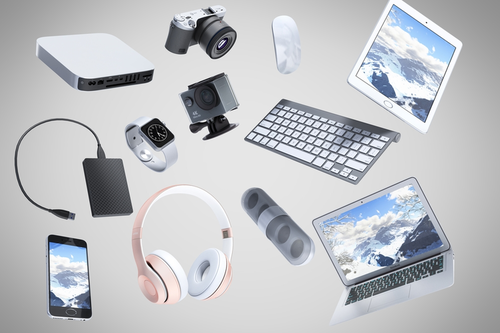

### About Dataset  

This file contains purchase data from January 2020 to November 2020 from a large home appliances and electronics online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 500)
pd.options.display.max_colwidth = 100
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('e-commerce.csv', index_col=0, parse_dates=['event_time'])

In [3]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171008.000,electronics.tablet,samsung,162.010,1515915625441993984.000
1,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171008.000,electronics.tablet,samsung,162.010,1515915625441993984.000
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000,electronics.audio.headphone,huawei,77.520,1515915625447879424.000
3,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000,electronics.audio.headphone,huawei,77.520,1515915625447879424.000
4,2020-04-26 08:45:57+00:00,2295716521449619559,1515966223509261697,2268105442636858112.000,furniture.kitchen.table,maestro,39.330,1515915625450382848.000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420718 entries, 0 to 420717
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     420718 non-null  datetime64[ns, UTC]
 1   order_id       420718 non-null  int64              
 2   product_id     420718 non-null  int64              
 3   category_id    420718 non-null  float64            
 4   category_code  420718 non-null  object             
 5   brand          420718 non-null  object             
 6   price          420718 non-null  float64            
 7   user_id        420718 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(2), object(2)
memory usage: 28.9+ MB


In [5]:
df.isnull().sum()

event_time       0
order_id         0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
dtype: int64

In [6]:
df.shape

(420718, 8)

**There are 420718 rows and 8 variables in the data set. There is no missing values**

In [7]:
df['event_time'].min(), df['event_time'].max()

(Timestamp('1970-01-01 00:33:40+0000', tz='UTC'),
 Timestamp('2020-11-21 10:10:30+0000', tz='UTC'))

In [8]:
df['event_time'][:5]

0   2020-04-24 11:50:39+00:00
1   2020-04-24 11:50:39+00:00
2   2020-04-24 14:37:43+00:00
3   2020-04-24 14:37:43+00:00
4   2020-04-26 08:45:57+00:00
Name: event_time, dtype: datetime64[ns, UTC]

In [9]:
df['event_time'] = pd.to_datetime(df.event_time).dt.tz_convert('Etc/GMT-3')

In [10]:
df['event_time'][:5]

0   2020-04-24 14:50:39+03:00
1   2020-04-24 14:50:39+03:00
2   2020-04-24 17:37:43+03:00
3   2020-04-24 17:37:43+03:00
4   2020-04-26 11:45:57+03:00
Name: event_time, dtype: datetime64[ns, Etc/GMT-3]

*We can take into account the time of the location of the e-commerce site for the analysis to be done correctly.

In [11]:
df['year'] = df.event_time.dt.year
df['month'] = df.event_time.dt.month
df['day_of_week'] = df.event_time.dt.dayofweek
df['hour'] = df.event_time.dt.hour

**I create these new columns because I will make analyzes on the basis of hours, days and months.**

In [12]:
df.year.value_counts()

2020    419890
1970       828
Name: year, dtype: int64

**Data for the 1970 year are inaccurate data.**

In [13]:
df = df.loc[df['year'] != 1970 ]

In [14]:
def hour_range(hour):
    if hour <= 3:
        return 'middle_of_night'
    elif hour <= 6:
        return 'early_morning'
    elif hour <= 9:
        return 'morning'
    elif hour <=12:
        return 'late_morning'
    elif hour <=15:
        return 'afternoon'
    elif hour <= 18:
        return 'late_afternoon'
    elif hour <=21:
        return 'evening'
    else:
        return 'night'

In [15]:
df['hour_range'] = df['hour'].map(hour_range)

In [16]:
df.drop(['year', 'hour'], axis=1, inplace=True)

In [17]:
df[['main_category', 'cat_2', 'cat_3']] = df['category_code'].str.rsplit('.', expand=True)

In [18]:
df['cat_3'] = df['cat_3'].fillna('')

In [19]:
df['sub_category'] = df['cat_2'] + '-' + df['cat_3']

**For a detailed analysis of categories, they need to be split into subcategories.**

In [20]:
df.drop(['category_code', 'cat_2', 'cat_3'], axis=1, inplace=True)

In [21]:
df.head(5)

,event_time,order_id,product_id,category_id,brand,price,user_id,month,day_of_week,hour_range,main_category,sub_category
0,2020-04-24 14:50:39+03:00,2294359932054536986,1515966223509089906,2268105426648171008.000,samsung,162.010,1515915625441993984.000,4,4,afternoon,electronics,tablet-
1,2020-04-24 14:50:39+03:00,2294359932054536986,1515966223509089906,2268105426648171008.000,samsung,162.010,1515915625441993984.000,4,4,afternoon,electronics,tablet-
2,2020-04-24 17:37:43+03:00,2294444024058086220,2273948319057183658,2268105430162997248.000,huawei,77.520,1515915625447879424.000,4,4,late_afternoon,electronics,audio-headphone
3,2020-04-24 17:37:43+03:00,2294444024058086220,2273948319057183658,2268105430162997248.000,huawei,77.520,1515915625447879424.000,4,4,late_afternoon,electronics,audio-headphone
4,2020-04-26 11:45:57+03:00,2295716521449619559,1515966223509261697,2268105442636858112.000,maestro,39.330,1515915625450382848.000,4,6,late_morning,furniture,kitchen-table


In [22]:
df['main_category'].unique()

array(['electronics', 'furniture', 'appliances', 'computers',
       'country_yard', 'accessories', 'kids', 'apparel', 'stationery',
       'construction', 'medicine', 'auto', 'sport'], dtype=object)

In [23]:
df['sub_category'].unique()

array(['tablet-', 'audio-headphone', 'kitchen-table', 'smartphone-',
       'kitchen-refrigerators', 'personal-scales', 'video-tv',
       'components-cpu', 'notebook-', 'peripherals-monitor',
       'peripherals-printer', 'kitchen-kettle', 'components-memory',
       'clocks-', 'weather_station-', 'kitchen-blender', 'bag-',
       'peripherals-mouse', 'iron-', 'kitchen-mixer', 'telephone-',
       'kitchen-meat_grinder', 'personal-hair_cutter',
       'environment-air_heater', 'skates-', 'kitchen-washer',
       'kitchen-microwave', 'bedroom-pillow', 'environment-vacuum',
       'environment-water_heater', 'living_room-shelving',
       'components-cooler', 'peripherals-joystick', 'network-router',
       'components-hdd', 'kitchen-hood', 'ironing_board-', 'glove-',
       'battery-', 'tools-screw', 'bedroom-bed', 'peripherals-keyboard',
       'cartrige-', 'environment-air_conditioner', 'kitchen-grill',
       'personal-massager', 'kitchen-toster', 'environment-fan', 'paper-',
      

In [24]:
df[['price']].describe([.05, .1, .25, .75, .9, .95, .99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
price,419890.000,254.282,321.168,0.000,6.920,12.710,39.330,138.870,347.200,648.130,879.610,1388.870,11574.050


**Even though the dataset seems to have outliers, i know it's made up of many different products. Thanks to the domain knowledge, i do not need to do anything to the observations that are more than the upper limit and appear to be outliers, but i will drop the products with a price of 0 from the data set.**


In [25]:
df = df[df['price'] != 0]

In [26]:
df.shape

(419886, 12)

## User Analysis

In [27]:
# how many unique users are there ? 

df['user_id'].nunique()

86915

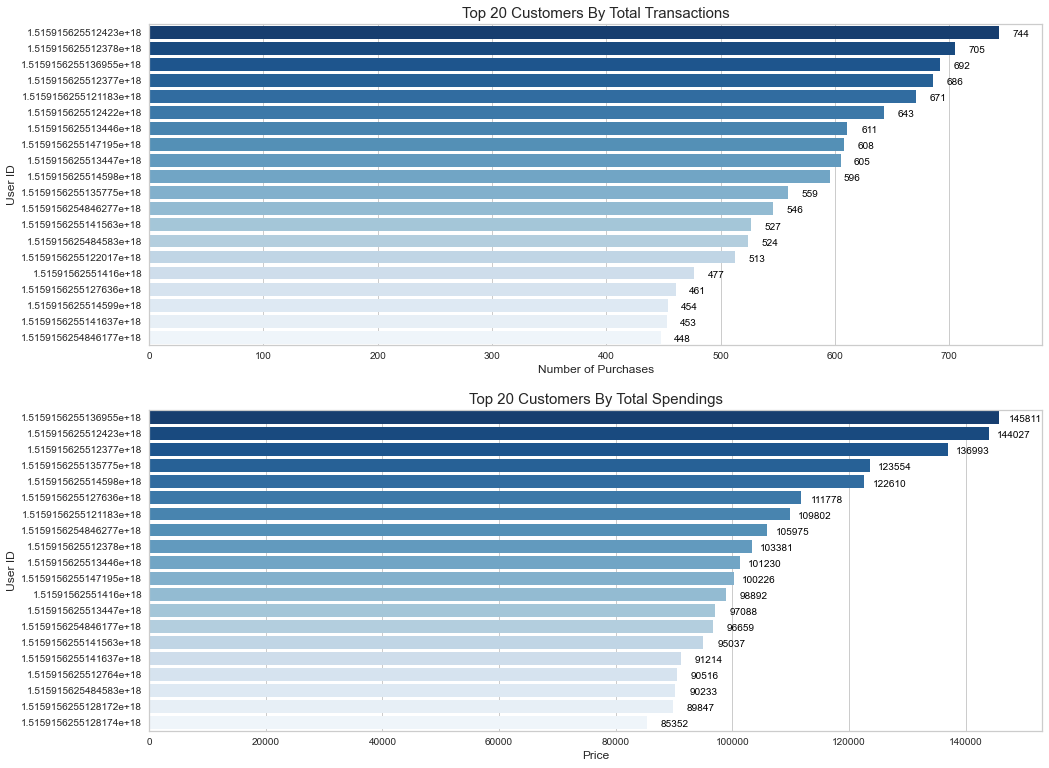

In [29]:
plt.figure(figsize=(16,13))
plt.subplot(2, 1, 1)
ax = sns.countplot(y='user_id', order=df['user_id'].value_counts().index[:20], data=df, palette='Blues_r')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(30, -11), 
                fontsize=10, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Top 20 Customers By Total Transactions', fontsize=15)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('User ID', fontsize=12)

df_customer = df.groupby('user_id')[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()[:20]
plt.subplot(2, 1, 2)
ax = sns.barplot(y="user_id",x="price", data=df_customer, palette='Blues_r', orient='h', order=df_customer['user_id'] )
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(42, -11),
                fontsize=10, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Top 20 Customers By Total Spendings', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('User ID', fontsize=12)
plt.show()

**!! There are customers who shop less frequently and spend more money.**

### Product Analysis

In [31]:
# how many unique products are there ? 

df['product_id'].nunique()

11543

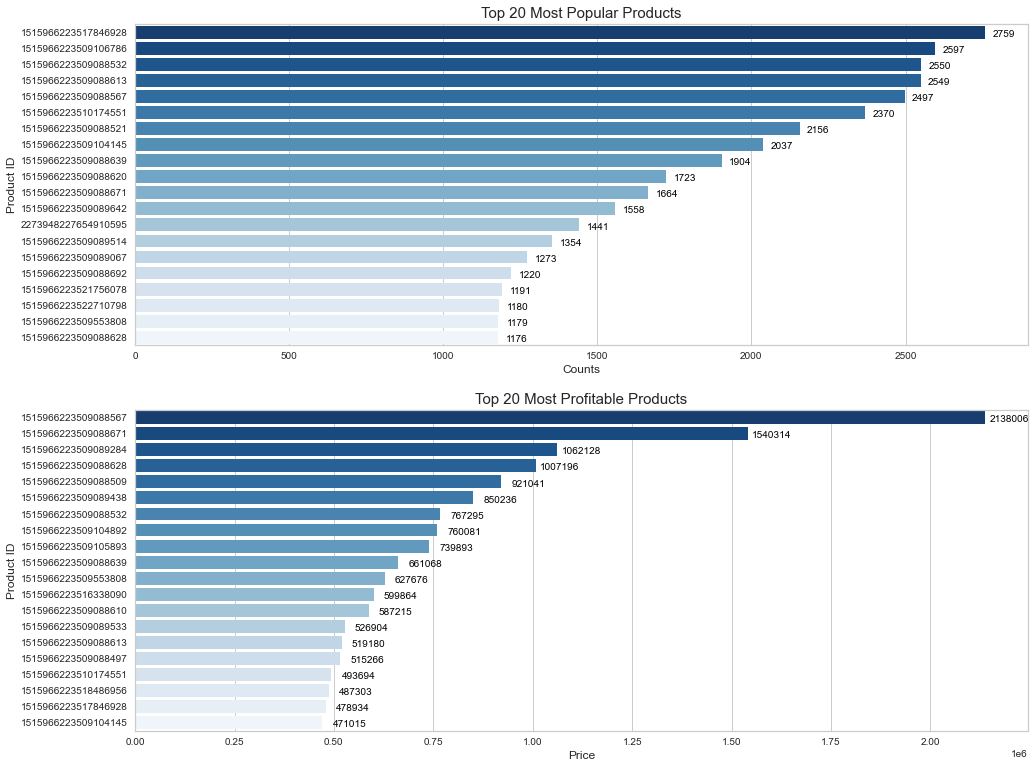

In [32]:
plt.figure(figsize=(16,13))
plt.subplot(2, 1, 1)
ax = sns.countplot(y = 'product_id', order=df['product_id'].value_counts().index[:20], data=df, palette='Blues_r')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(30, -11), 
                fontsize=10, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Top 20 Most Popular Products', fontsize=15)
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Product ID', fontsize=12)

df_ = df.groupby('product_id')[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()[:20]
plt.subplot(2, 1, 2)
ax = sns.barplot(y="product_id",x="price", data=df_, palette='Blues_r', orient='h', order=df_['product_id'] )
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(44, -11),
                fontsize=10, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Top 20 Most Profitable Products', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Product ID', fontsize=12)
plt.show()

**Similar to customer graphs, there are products that sell less, but bring more profit.For example, the product that brings the most profit is 5th in the list of the most selling products**

## Category Analysis

### 1- Main Category Analysis

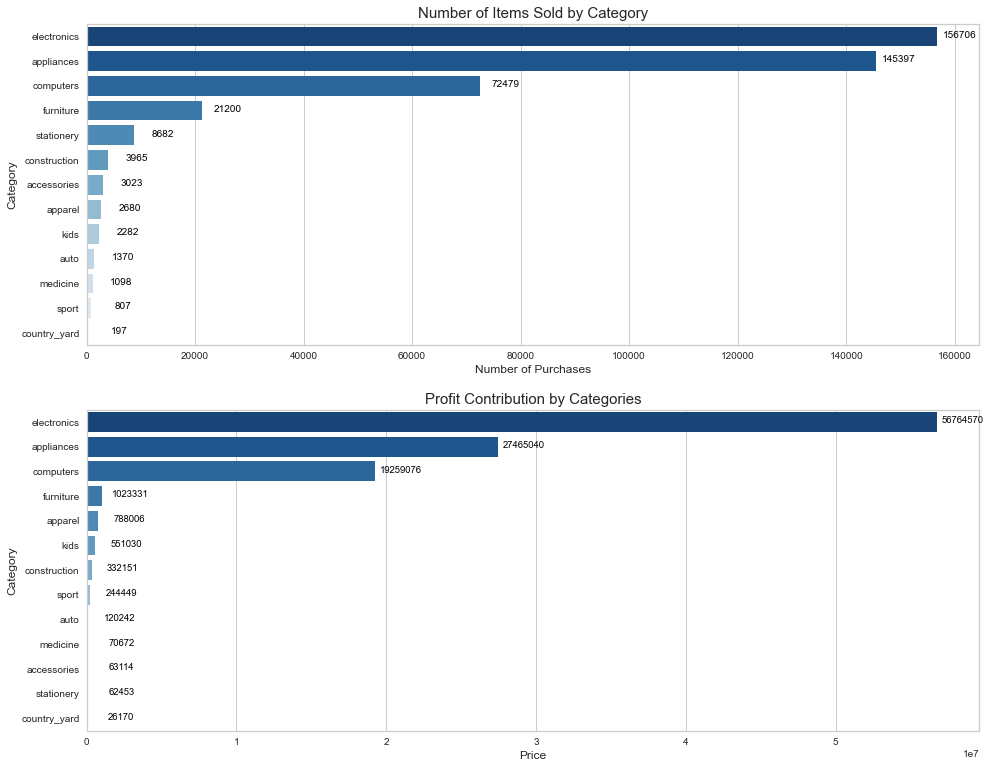

In [33]:
plt.figure(figsize=(16,13))
plt.subplot(2, 1, 1)

ax = sns.countplot(y='main_category', order=df['main_category'].value_counts().index, data=df, palette='Blues_r')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(40, -11), 
                fontsize=10, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Number of Items Sold by Category', fontsize=15)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Category', fontsize=12)

df_cat = df.groupby('main_category')[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()[:20]
plt.subplot(2, 1, 2)
ax = sns.barplot(y='main_category',x='price', data=df_cat, palette='Blues_r', orient='h', order=df_cat['main_category'])
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(47, -11),
                fontsize=9.5, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Profit Contribution by Categories', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

**Sports products bring more profit than many products that are sold more than themselves.**

### 2-Sub-Category Analysis

In [34]:
# how many unique subcategories are there ? 

df['sub_category'].nunique()

123

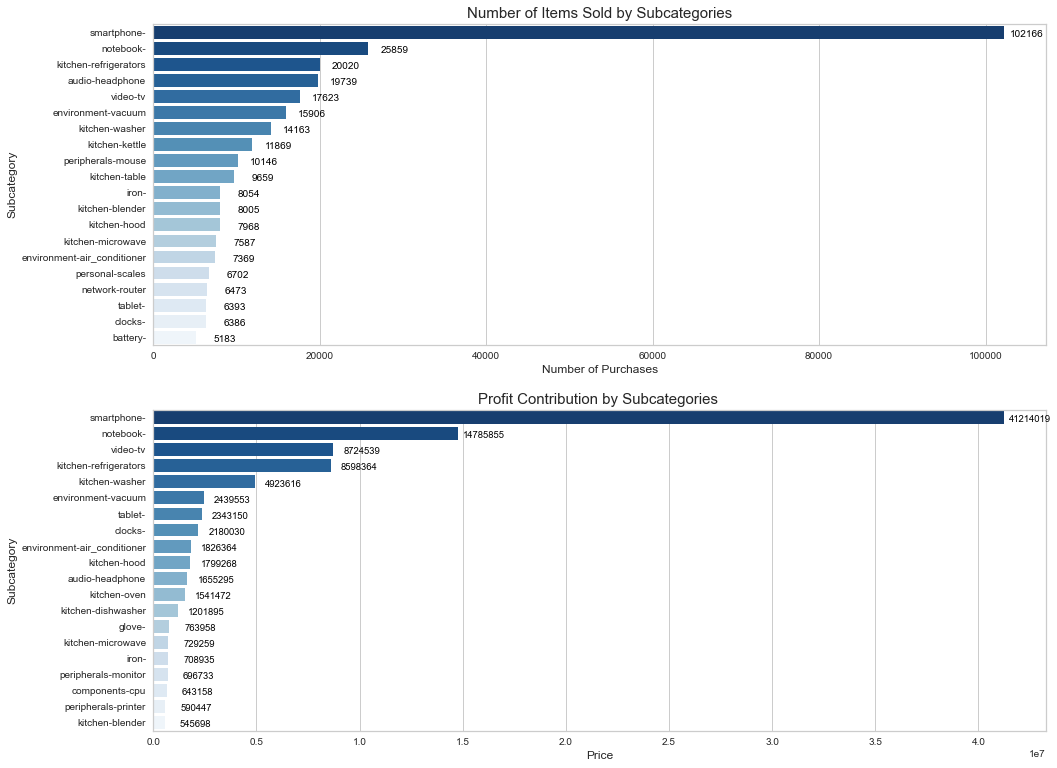

In [35]:
plt.figure(figsize=(16,13))
plt.subplot(2, 1, 1)

ax = sns.countplot(y='sub_category', order=df['sub_category'].value_counts().index[:20], data=df, palette='Blues_r')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(40, -11), 
                fontsize=10, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Number of Items Sold by Subcategories', fontsize=15)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Subcategory', fontsize=12)

df_sub = df.groupby('sub_category')[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()[:20]
plt.subplot(2, 1, 2)
ax = sns.barplot(y='sub_category',x='price', data=df_sub, palette='Blues_r', orient='h', order=df_sub['sub_category'])
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(47, -11),
                fontsize=9.5, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Profit Contribution by Subcategories ', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Subcategory', fontsize=12)
plt.show()

## Brand Analysis

In [36]:
# how many unique brands are there ? 

df['brand'].nunique()

570

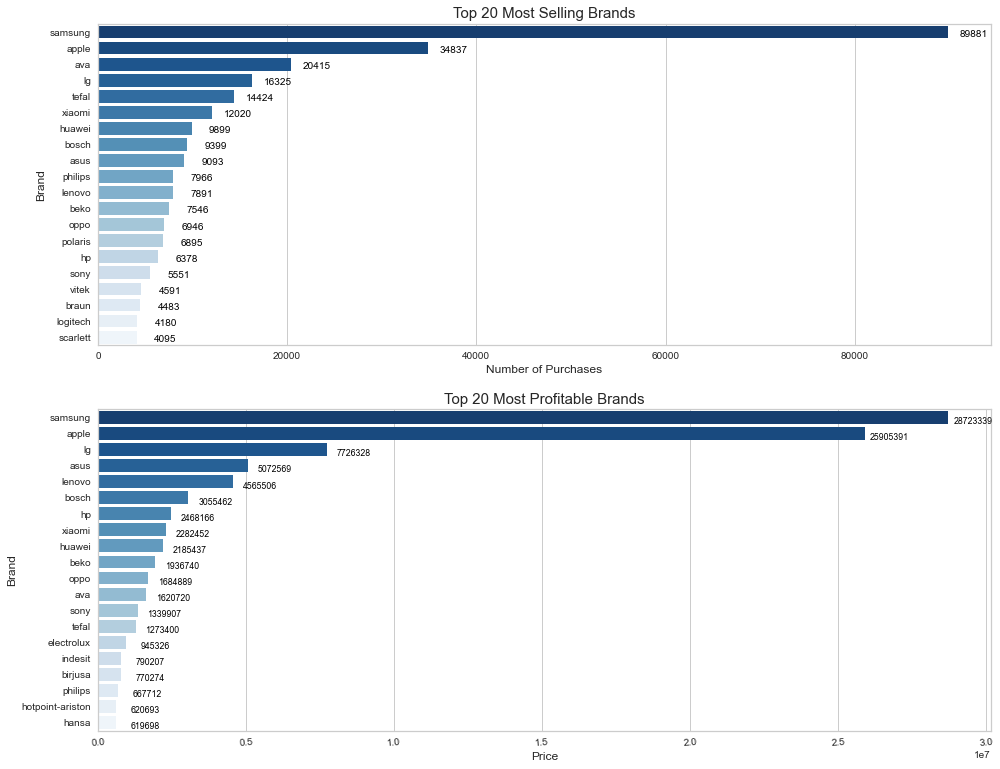

In [37]:
plt.figure(figsize=(16,13))
plt.subplot(2, 1, 1)
ax = sns.countplot(y = 'brand', order=df['brand'].value_counts().index[:20], data=df, palette='Blues_r')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(40, -11), 
                fontsize=10, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Top 20 Most Selling Brands', fontsize=15)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Brand', fontsize=12)


df_brand = df.groupby('brand')[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()[:20]
plt.subplot(2, 1, 2)
ax = sns.barplot(y='brand',x='price', data=df_brand, palette='Blues_r', orient='h', order=df_brand['brand'])
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(44, -13),
                fontsize=8.7, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Top 20 Most Profitable Brands', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.xticks(rotation=5);

**We can clearly see that the average price of products sold from the Apple is higher**

## Some Details

#### Profit Contribution of Categories by Month

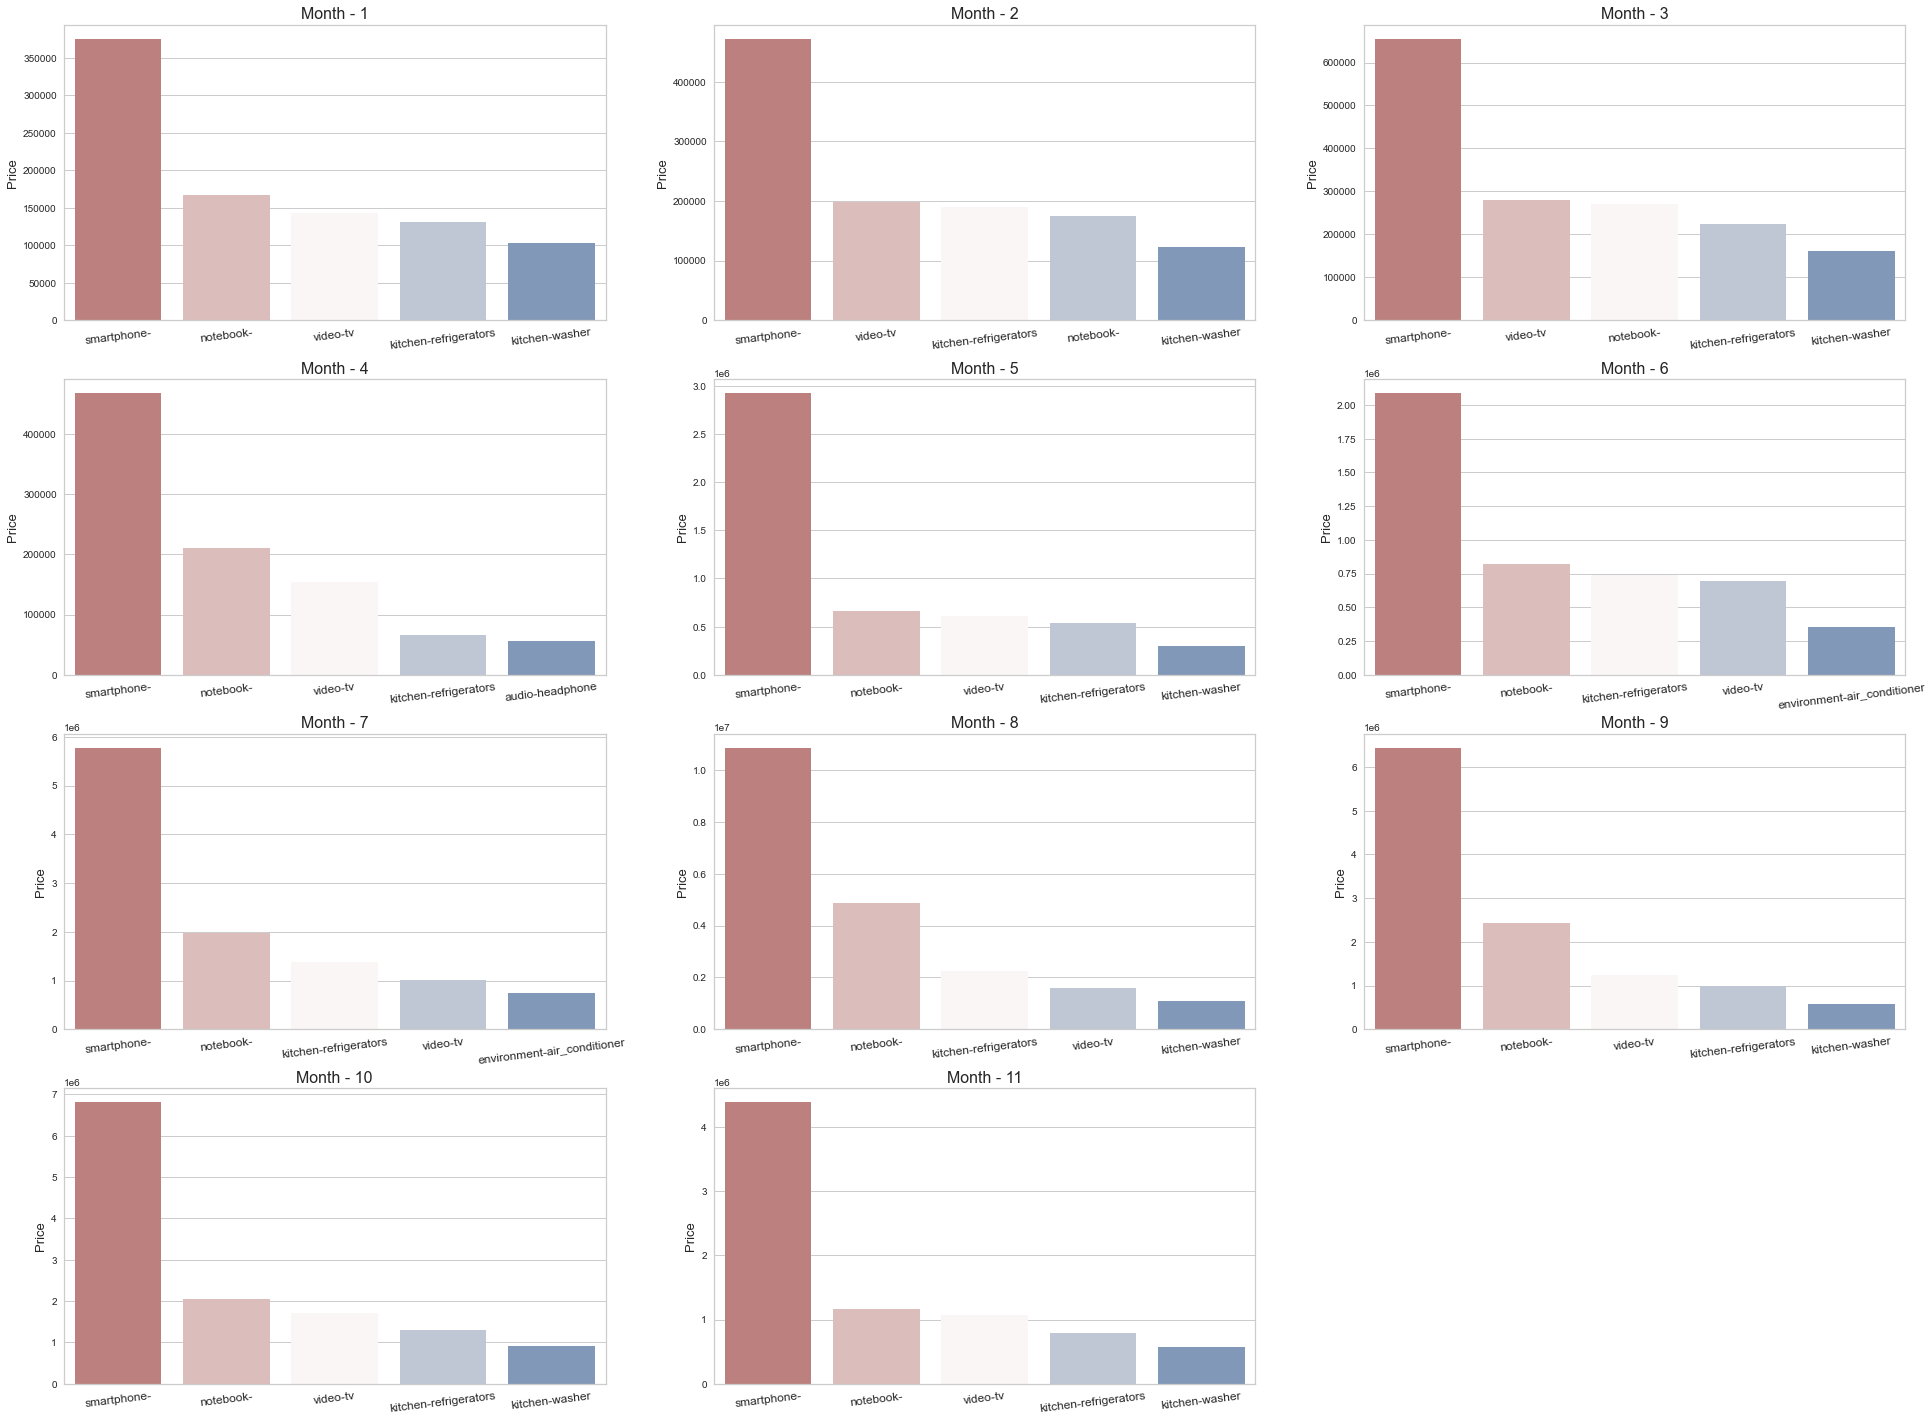

In [38]:
plt.figure(figsize=(33, 25))
for i in df.month.unique():
    plt.subplot(4, 3, i)
    df_month_cat = df[df['month'] == i].groupby('sub_category')[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()[:5]
    ax = sns.barplot(x='sub_category',y="price", data=df_month_cat, palette='vlag_r', order=df_month_cat['sub_category'])
    ax.set(xlabel=None)
    plt.ylabel('Price', fontsize=13)
    plt.xticks(rotation=7, fontsize=12)
    plt.title(f"Month - {i}",fontsize=16)
plt.show()

- The smartphone has held the lead for 11 months.
- The competition between notebook, refrigerator and TV has been going on for 11 months.
- Sales of air conditioner products increased in June and July.

#### Profit Contribution of Brands by Month

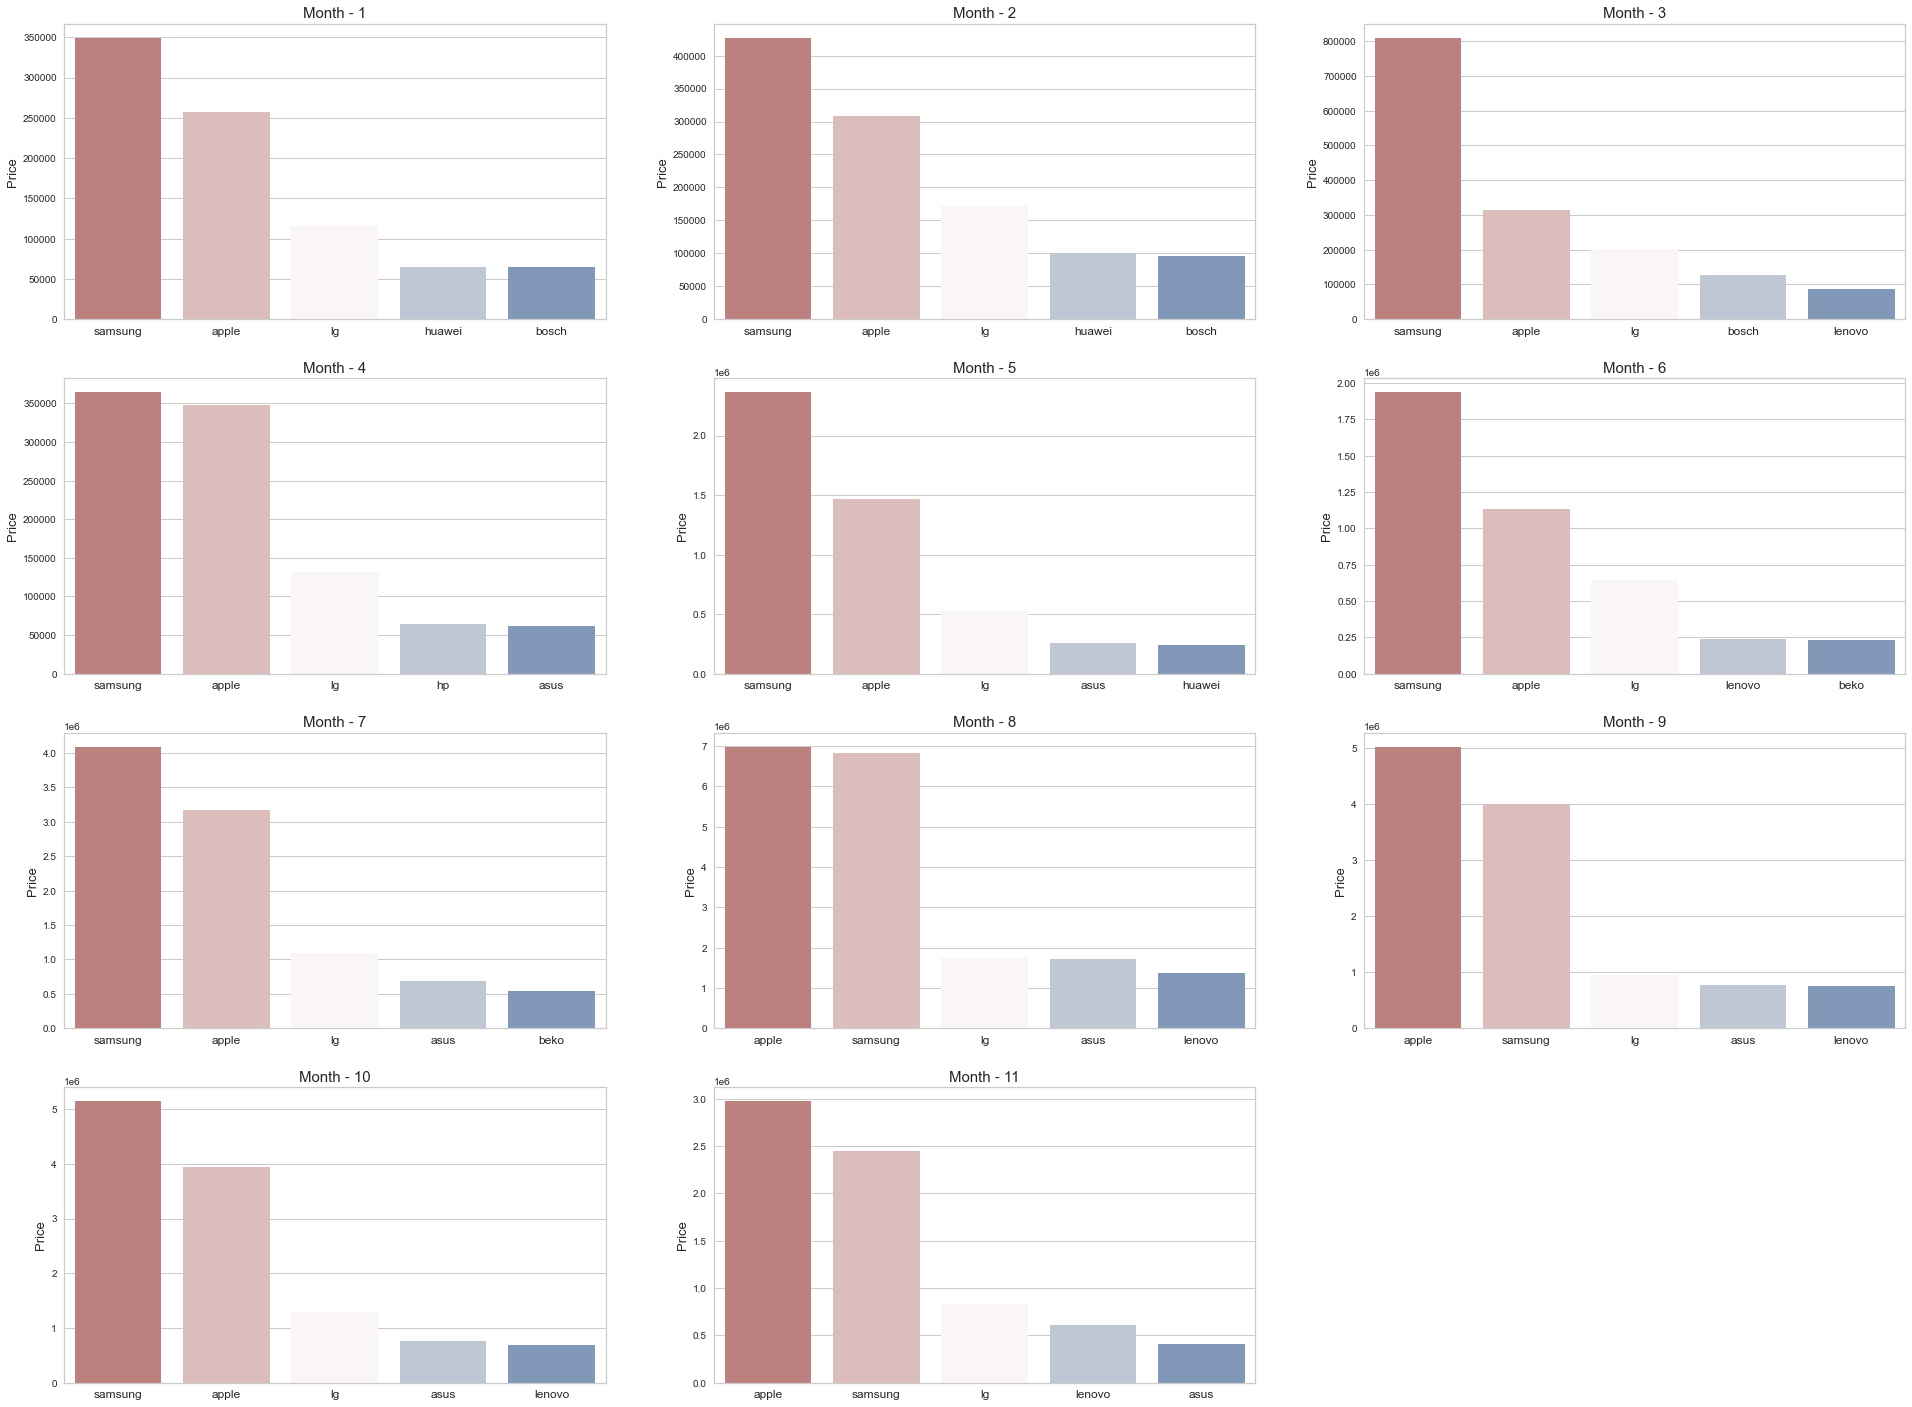

In [39]:
plt.figure(figsize=(33, 25))
for i in df.month.unique():
    plt.subplot(4, 3, i)
    df_month_brand = df[df['month']==i].groupby('brand')[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()[:5]
    ax = sns.barplot(x="brand", y="price", data=df_month_brand, palette='vlag_r', order=df_month_brand['brand'])
    ax.set(xlabel = None)
    plt.ylabel('Price', fontsize=13)
    plt.xticks(fontsize=12)
    plt.title(f"Month - {i}", fontsize=15)
plt.show()

In [40]:
df.groupby(['month','brand'])[['price']].sum().\
                            sort_values(by='price', ascending=False).reset_index()

,month,brand,price
0,8,apple,6976117.810
1,8,samsung,6813193.590
2,10,samsung,5140358.260
3,9,apple,5016952.210
4,7,samsung,4088552.220
...,...,...,...
3588,11,rossija,0.420
3589,9,x-cooler,0.420
3590,10,rossija,0.420
3591,5,pedigree,0.230


- Apple products have been bringing more profit in recent months.
- While LG has been maintaining 3rd place for 11 months, there is a tight competition among other brands.

#### Monthly, Daily and Hourly Profit Analysis

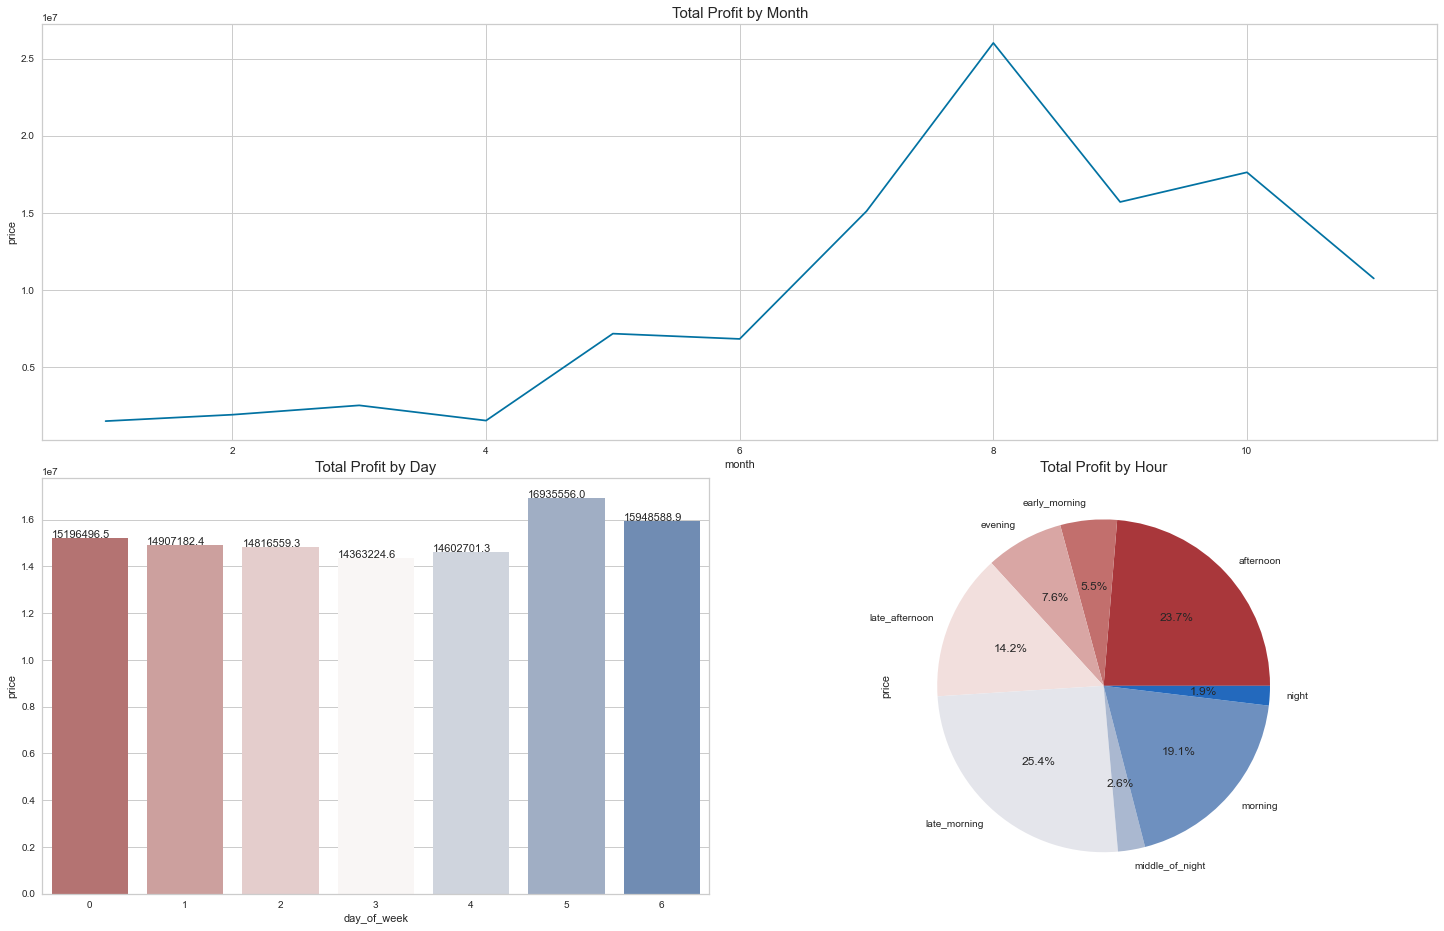

In [41]:
plt.figure(figsize=(25, 16))
gs = gridspec.GridSpec(4,4)
ax1 = plt.subplot(gs[:2, :])
month = df.groupby('month')[['price']].sum().reset_index()
sns.lineplot(x='month',y='price', data=month)
plt.title('Total Profit by Month', fontsize=15)

ax2 = plt.subplot(gs[2:4, :2])
day_of_week = df.groupby('day_of_week')[['price']].sum().reset_index()
sns.barplot(x='day_of_week',y='price', data=day_of_week, palette='vlag_r')
for p in ax2.patches:
    ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+50), fontsize=11)
plt.title('Total Profit by Day', fontsize=15)

ax3 = plt.subplot(gs[2:4:, 2:])
df.groupby('hour_range')['price'].sum().plot(kind='pie', autopct='%1.1f%%',cmap='vlag_r')
plt.title('Total Profit by Hour', fontsize=15)
plt.show()
                                                

*0=Monday , 6=Sunday

- The company realized 49.1% of its profit between 9 and 15 o'clock.
- The highest profit was achieved in August.
- Finally, it is seen that the profitability increased over the weekend.

# RFM Segmentation

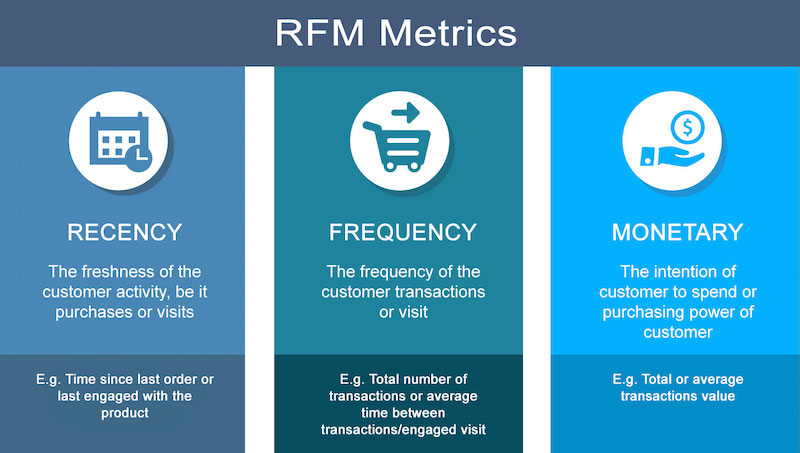

RFM model is a proven marketing strategy based on customer behavior segmentation. It groups customers based on their purchase history – how recently, with what Frequency, and what value they bought. This allows companies to target specific clusters of customers with greater relevance for their particular behavior – thereby generating higher response rates, increased loyalty, and better customer lifetime value.

In [39]:
df['event_time'] = pd.to_datetime(df.event_time).dt.tz_localize(None)

*Timestamp subtraction must have the same timezones or no timezones

In [40]:
df['event_time'].max()

Timestamp('2020-11-21 13:10:30')

In [41]:
today_date = dt.datetime(2020, 11, 23)

**The last date we have is 2020-11-21 so i will use date 2020-11-23 as reference**

In [42]:
rfm = df.groupby('user_id').agg({'event_time': lambda event_time: (today_date - event_time.max()).days,
                                 'order_id': lambda order_id: order_id.nunique(),
                                 'price': lambda price: price.sum()})

In [43]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [44]:
rfm.head()

,recency,frequency,monetary
user_id,,,
1515915625439951872.000,136,1,416.640
1515915625440038400.000,25,2,56.430
1515915625440051712.000,6,4,5984.920
1515915625440099840.000,47,5,3785.720
1515915625440121600.000,131,2,182.830


In [45]:
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

**We assign a score from 1 to 5 to Recency, Frequency, and Monetary.It is better from the company's point of view that a customer has a low recency value.So we assign high recency score to low recency value**

In [46]:
rfm['RFM_SCORE'] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [47]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

- **Hibernating** :  The last purchase was long back and a low number of orders. May be lost. 

- **Can't loose** : The customer value of the members of this segment is above average but they have not made a purchase recently.

- **At Risk** : Similar to “Can’t lose them” but with a smaller frequency value.

- **About to Sleep** : The customers in this segment have not made a purchase in a relatively long time but not to the extent that they are unapproachable. Hence, their interest might possibly be revived 

- **Need Attention** : These customers are core customers who probably consider now from whom should they buy a product next.

- **Loyal Customer** : These are very active and therefore very valuable customers.

- **Promising**: These customers bought from you relatively recently for high value but they have not been frequent customers - possibly this is their first purchase from your website.

- **New Customers**: These customers bought from you relatively recently for average or below-average price and they have not been frequent customers - possibly this is their first purchase from your website.

- **Potential Loyalist** : Recent customers with average frequency.

- **Champions** : These customers are responsible for a big share of your revenue so put a lot of effort into keeping them happy


In [48]:
rfm[['segment', 'recency', 'frequency', 'monetary']].groupby('segment').agg(['mean', 'median', 'count'])

recency                frequency               monetary                
                       mean  median  count      mean median  count     mean   median  count
segment                                                                                    
about_to_sleep      102.680 103.000   7491     1.000  1.000   7491  361.333  249.980   7491
at_risk             144.455 131.000  10063     2.328  2.000  10063  682.501  485.830  10063
cant_loose          130.341 122.000   2018     5.692  5.000   2018 1881.853 1334.775   2018
champions            25.110  26.000  11950    14.011  5.000  11950 4161.785 1613.250  11950
hibernating         157.999 152.000  22037     1.000  1.000  22037  284.502  162.010  22037
loyal_customers      85.659  87.000  17189     4.488  4.000  17189 1706.020 1159.660  17189
need_attention      102.503 103.000   2479     1.967  2.000   2479  684.532  499.960   2479
new_customers        28.550  31.000    904     1.000  1.000    904  393.021  231.460    904
potential_loyalists  53.178  59.000  11023     1.349  1.000  11023  490.157  314.790  11023
promising            73.507  74.000   1761     1.000  1.000   1761  349.267  208.310   1761

In [49]:
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
user_id,,,,,,,,
1515915625439951872.000,136,1,416.640,2,1,3,21,hibernating
1515915625440038400.000,25,2,56.430,5,3,1,53,potential_loyalists
1515915625440051712.000,6,4,5984.920,5,4,5,54,champions
1515915625440099840.000,47,5,3785.720,5,5,5,55,champions
1515915625440121600.000,131,2,182.830,2,3,2,23,at_risk
1515915625440881408.000,6,36,22916.990,5,5,5,55,champions
1515915625440936192.000,16,10,5005.550,5,5,5,55,champions
1515915625440936704.000,89,20,12087.410,4,5,5,45,loyal_customers
1515915625440936960.000,7,10,10563.410,5,5,5,55,champions


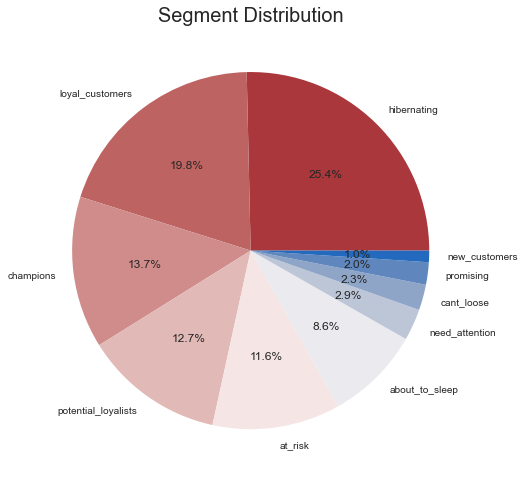

In [51]:
plt.figure(figsize=(8, 10))
ax = rfm['segment'].value_counts().plot(kind='pie', autopct='%1.1f%%',cmap='vlag_r')
plt.title('Segment Distribution', fontsize=20)
ax.set(ylabel = None);

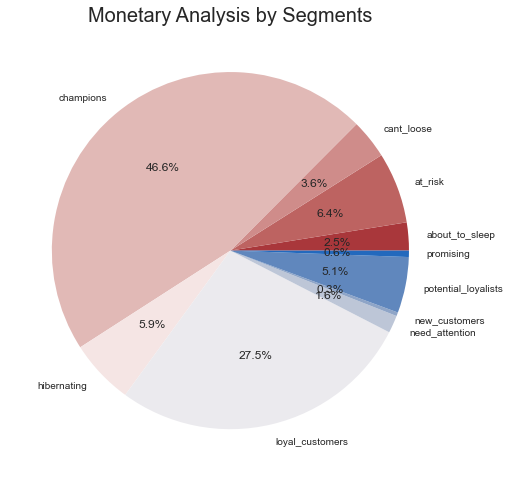

In [52]:
plt.figure(figsize=(8, 10))
ax = rfm.groupby('segment')['monetary'].sum().plot(kind='pie', autopct='%1.1f%%',cmap='vlag_r')
plt.title('Monetary Analysis by Segments', fontsize=20)
ax.set(ylabel = None);

- The company earns 46.6 percent of its profits from the **champions** segment.The company should reward customers in this segment.They can become early adopters of new products. They will promote your brand.

- A personalized email or other messages should be sent to the **at-risk** segment. Good offers should be provided.

- Although the **hibernating** segment occupies an important place in numbers, investments that can be made for this group may be to the detriment of the business. Overspending should not be made for this segment.

- It can be tried to motivate them to increase the number of products in their basket by showing cross-selling suggestions for the **potential loyalist** segment.  

- Create more brand awareness for customers **promising segment**. Provide free trials.

# Customer Lifetime Value

Customer Lifetime Value tells us how much value we expect to get from a single customer. For example, if a customer signs up for your product for nine months, the amount he/she will pay during that period will determine his/her lifetime value.  
CLTV tells you how valuable a customer is to your brand and gives you an idea of its overall value. It helps you understand how much you need to invest to retain this customer.

$$*CLTV =  \frac{Customer\ Value * Profit\ Margin}{Churn Rate}$$  


$$*Customer\ Value = {Average\ Order\ Value * Purchase\ Frequency}$$  


$$*Average\ Order\ Value = \frac{Total\ Price}{Total\ Transaction}$$  


$$*Purchase\ Frequency = \frac{Total\ Transaction}{Total\ Number\ of\ Customers}$$  


$$*Churn\ Rate = {1 - Repeat\ Rate}$$  


$$*Repeat\ Rate = \frac{Number\ of\ customers\ who\ have \ made\ more\ than\ one\ purchase}{Total\ Number\ of\ Customers}$$  


In [53]:
cltv = df.groupby('user_id').agg({'order_id':'nunique',
                                  'product_id': 'count',
                                  'price':'sum'})

In [54]:
cltv.columns = ['total_transaction', 'total_unit', 'total_price']

In [55]:
cltv.head()

,total_transaction,total_unit,total_price
user_id,,,
1515915625439951872.000,1,1,416.640
1515915625440038400.000,2,2,56.430
1515915625440051712.000,4,12,5984.920
1515915625440099840.000,5,7,3785.720
1515915625440121600.000,2,2,182.830


**Total unit column refers to how many products customers bought. It will be used for the analysis of segments.**

In [56]:
cltv['average_order_value'] = cltv['total_price'] / cltv['total_transaction']

In [57]:
#the impact of the whole customers

cltv['purchase_frequency'] = cltv['total_transaction'] / cltv.shape[0] 

In [58]:
repeat_rate = cltv[cltv['total_transaction'] > 1].shape[0] / cltv.shape[0]

In [59]:
repeat_rate

0.5458436403382615

**About 45% of customers never shopped after shopping once.**

In [60]:
churn_rate = 1 - repeat_rate

**Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain.**

In [61]:
#Let’s assume that business making 5% profit.

cltv['profit_margin'] = cltv['total_price'] * 0.05

In [62]:
cltv['customer_value'] = cltv['average_order_value'] * cltv['purchase_frequency']

In [63]:
cltv['cltv'] = (cltv['customer_value'] / churn_rate) * cltv['profit_margin']

In [64]:
cltv.sort_values(by='cltv', ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
user_id,,,,,,,,
1515915625513695488.000,499,692,145811.240,292.207,0.006,7290.562,1.678,26930.963
1515915625512422912.000,524,744,144027.060,274.861,0.006,7201.353,1.657,26275.928
1515915625512377088.000,521,686,136993.300,262.943,0.006,6849.665,1.576,23772.153
1515915625513577472.000,395,559,123554.670,312.797,0.005,6177.734,1.422,19336.960
1515915625514597888.000,426,596,122610.270,287.818,0.005,6130.514,1.411,19042.483


In [65]:
cltv_kmeans = cltv.copy()

In [66]:
cltv['segment'] = pd.qcut(cltv['cltv'], 3, labels=['S3', 'S2', 'S1'])

In [67]:
cltv.sort_values(by='cltv', ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
user_id,,,,,,,,,
1515915625513695488.000,499,692,145811.240,292.207,0.006,7290.562,1.678,26930.963,S1
1515915625512422912.000,524,744,144027.060,274.861,0.006,7201.353,1.657,26275.928,S1
1515915625512377088.000,521,686,136993.300,262.943,0.006,6849.665,1.576,23772.153,S1
1515915625513577472.000,395,559,123554.670,312.797,0.005,6177.734,1.422,19336.960,S1
1515915625514597888.000,426,596,122610.270,287.818,0.005,6130.514,1.411,19042.483,S1


In [68]:
cltv.groupby('segment').agg({'count', 'mean', 'median'})

total_transaction               total_unit               total_price                 average_order_value                purchase_frequency               profit_margin               customer_value                 cltv              
                     mean median  count       mean median  count        mean   median  count                mean  median  count               mean median  count          mean median  count           mean median  count   mean median  count
segment                                                                                                                                                                                                                                       
S3                  1.293  1.000  28999      1.455  1.000  28999     108.686  104.140  28999              92.059  74.050  28999              0.000  0.000  28999         5.434  5.207  28999          0.001  0.001  28999  0.022  0.014  28999
S2                  1.965  2.000  29131      2.303  2.000  29131     505.057  474.490  29131             330.666 289.330  29131              0.000  0.000  29131        25.253 23.725  29131          0.006  0.005  29131  0.363  0.285  29131
S1                  8.223  4.000  28785     10.791  5.000  28785    3088.612 1637.540  28785             599.875 486.090  28785              0.000  0.000  28785       154.431 81.877  28785          0.036  0.019  28785 61.680  3.397  28785

**As can be seen statistically, S1 segment is the most active and important segment of the company.These customers are responsible for a big share of company's revenue so put a lot of effort into keeping them happy.**

### K-Means Clustering

In [69]:
sc = MinMaxScaler((0, 1))
cltv_kmeans = sc.fit_transform(cltv_kmeans)

In [70]:
kmeans = KMeans(n_clusters=3, random_state=17).fit(cltv_kmeans)

In [71]:
kmeans.labels_

array([0, 0, 2, ..., 0, 2, 0], dtype=int32)

In [72]:
kmeans.inertia_

211.8657530002696

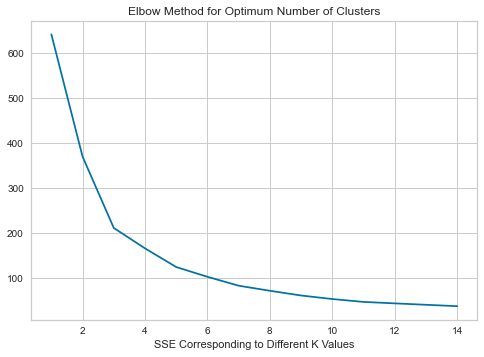

In [73]:
kmeans = KMeans()
ssd = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(cltv_kmeans)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("SSE Corresponding to Different K Values")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

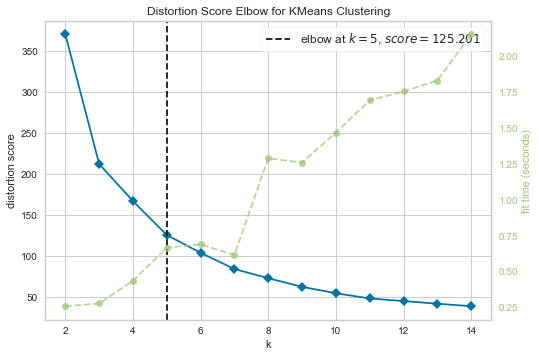

In [74]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 15))
elbow.fit(cltv_kmeans)
elbow.show();

In [75]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(cltv_kmeans)

In [76]:
clusters_kmeans = kmeans.labels_

In [77]:
cltv['cluster_kmeans'] = clusters_kmeans

In [78]:
cltv.groupby('cluster_kmeans').agg(['count', 'mean', 'median'])

total_transaction                 total_unit                 total_price                     average_order_value                   purchase_frequency              profit_margin                   customer_value                cltv                  
                           count    mean  median      count    mean  median       count      mean    median               count     mean   median              count  mean median         count     mean   median          count  mean median  count     mean   median
cluster_kmeans                                                                                                                                                                                                                                                        
0                          57818   2.413   2.000      57818   2.823   2.000       57818   446.194   253.555               57818  165.667  161.780              57818 0.000  0.000         57818   22.310   12.678          57818 0.005  0.003  57818    0.724    0.081
1                            229 236.956 222.000        229 322.555 301.000         229 56865.467 52112.880                 229  243.273  232.917                229 0.003  0.003           229 2843.273 2605.644            229 0.654  0.600    229 4537.399 3440.012
2                          24238   3.335   2.000      24238   4.320   2.000       24238  1791.467  1180.490               24238  588.016  538.500              24238 0.000  0.000         24238   89.573   59.025          24238 0.021  0.014  24238    8.114    1.765
3                           4068   2.252   1.000       4068   3.618   2.000        4068  2913.355  1863.400                4068 1354.829 1215.250               4068 0.000  0.000          4068  145.668   93.170           4068 0.034  0.021   4068   21.078    4.398
4                            562  84.776  78.000        562 112.726 103.000         562 22556.911 20827.415                 562  305.412  247.223                562 0.001  0.001           562 1127.846 1041.371            562 0.260  0.240    562  753.277  549.466

## Conclusion 

- Customer Lifetime Value is a tool, not a strategy. CLTV can figure out most profitable customers, but how you are going to make a profit from them, it depends on your strategy.
- In the clustering study conducted with K-means, we see that a minority(229 customers) of its customers actually cover the majority of the company's revenue.
- Another striking finding is that although the average order value of the S3 segment is quite high, the shopping frequency and the total number of units purchased are low. Special offers can be offered for these customers to make purchases more often and maintain loyalty.
- Segment 4 is customers who shop frequently and buy a large number of products.By engaging with them, more expensive products can be sold.They are second most valuable segment in terms of cltv value.
- Finally, Probabilistic models can be used for time-projected prediction of cltv value.